## Lê Thành Danh: EXPLORATORY DATA ANALYSIS & CLUSTERING - PHÂN TÍCH KHÁM PHÁ DỮ LIỆU (EDA) & PHÂN CỤM


### 1. Khai báo thư viện

In [26]:
# 1. Khai báo thư viện

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

### 2. Tải dữ liệu

In [27]:
# 2. Tải dữ liệu
print("PHẦN 2: Phân tích phân cụm (Clustering Analysis)")

df = pd.read_csv('data/cleaned_data.csv')
print(f"\n Đã load cleaned data: {df.shape[0]:,} rows × {df.shape[1]} columns")

PHẦN 2: Phân tích phân cụm (Clustering Analysis)

 Đã load cleaned data: 99,457 rows × 29 columns


### 3. Chuẩn bị dữ liệu cho clustering

In [28]:
if all(col in df.columns for col in ['recency', 'frequency', 'monetary']):
    # Aggregate theo customer_id
    rfm_df = df.groupby('customer_id').agg({
        'recency': 'mean',
        'frequency': 'mean',
        'monetary': 'mean'
    }).reset_index()
    
    print(f"Số khách hàng: {len(rfm_df):,}")
    print(f"Features: Recency, Frequency, Monetary")
    
    # Chuẩn hóa RFM
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_df[['recency', 'frequency', 'monetary']])
    
    print("\n  RFM Statistics:")
    print(rfm_df[['recency', 'frequency', 'monetary']].describe())

Số khách hàng: 99,457
Features: Recency, Frequency, Monetary

  RFM Statistics:
            recency  frequency      monetary
count  99457.000000    99457.0  99457.000000
mean     396.884030        1.0   2528.789268
std      229.871351        0.0   4222.475781
min        0.000000        1.0      5.230000
25%      198.000000        1.0    136.350000
50%      396.000000        1.0    600.170000
75%      597.000000        1.0   2700.720000
max      796.000000        1.0  26250.000000


### 4. Phương pháp phân cụm 1: K-Means

#### 4.1. Phương pháp Elbow - Tìm k tối ưu

1. Phương pháp Elbow - Tìm k tối ưu:
k=2, WCSS=124354.09, Silhouette=0.4267
k=3, WCSS=67882.96, Silhouette=0.4857
k=4, WCSS=49964.69, Silhouette=0.4962
k=5, WCSS=38364.75, Silhouette=0.4408
k=6, WCSS=28650.89, Silhouette=0.4815
k=7, WCSS=23870.43, Silhouette=0.4888
k=8, WCSS=20208.95, Silhouette=0.4554
k=9, WCSS=17460.84, Silhouette=0.4584
k=10, WCSS=15173.82, Silhouette=0.4610


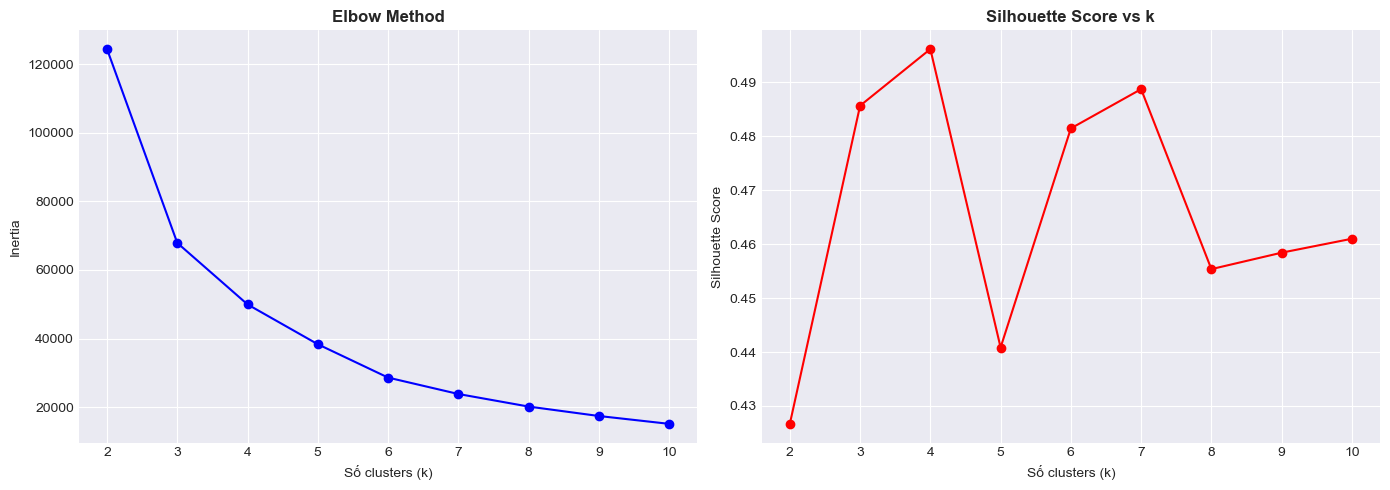

Đã lưu: figures/05_elbow_method.png
K tối ưu: 4 (Silhouette Score: 0.4962)


In [29]:
# 8.1 Elbow Method
print("1. Phương pháp Elbow - Tìm k tối ưu:")
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    # 1. Chạy KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)
    
    # 2. Tính Silhouette (Sample 10000 dòng)
    sample_size = 10000 if len(rfm_scaled) > 10000 else None
    score = silhouette_score(rfm_scaled, kmeans.labels_, sample_size=sample_size, random_state=42)
    silhouette_scores.append(score)
    
    # In ra thông số
    print(f"k={k}, WCSS={kmeans.inertia_:.2f}, Silhouette={score:.4f}")

# Biểu đồ Elbow
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Số clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method', fontweight='bold')
axes[0].grid(True)

axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Số clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs k', fontweight='bold')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('figures/05_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: figures/05_elbow_method.png")

# Chọn k tối ưu (k có silhouette score cao nhất)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"K tối ưu: {optimal_k} (Silhouette Score: {max(silhouette_scores):.4f})")

#### 4.2. Huấn luyện K-Means

In [30]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_df['kmeans_cluster'] = kmeans_final.fit_predict(rfm_scaled)

# Đánh giá
silhouette_avg = silhouette_score(rfm_scaled, rfm_df['kmeans_cluster'])
davies_bouldin = davies_bouldin_score(rfm_scaled, rfm_df['kmeans_cluster'])
calinski_harabasz = calinski_harabasz_score(rfm_scaled, rfm_df['kmeans_cluster'])

print(f"Chỉ số đánh giá(Metrics):")
print(f"  - Chỉ số Silhouette: {silhouette_avg:.4f}")
print(f"  - Chỉ số Davies-Bouldin: {davies_bouldin:.4f} (thấp hơn là tốt hơn)")
print(f"  - Chỉ số Calinski-Harabasz: {calinski_harabasz:.2f} (cao hơn là tốt hơn)")

Chỉ số đánh giá(Metrics):
  - Chỉ số Silhouette: 0.4992
  - Chỉ số Davies-Bouldin: 0.8280 (thấp hơn là tốt hơn)
  - Chỉ số Calinski-Harabasz: 98826.32 (cao hơn là tốt hơn)


#### 4.3. Trực quan hóa các cụm K-Means

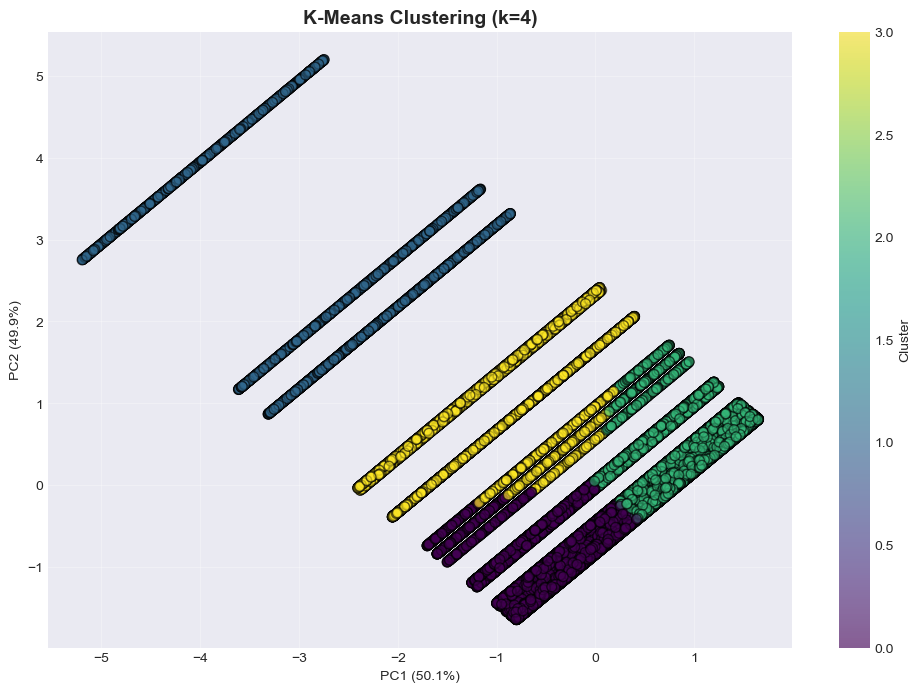

Đã lưu: figures/06_kmeans_clusters.png


In [31]:
# PCA to 2D
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], 
                     c=rfm_df['kmeans_cluster'], 
                     cmap='viridis', 
                     alpha=0.6, 
                     edgecolors='black',
                     s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title(f'K-Means Clustering (k={optimal_k})', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.savefig('figures/06_kmeans_clusters.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: figures/06_kmeans_clusters.png")